## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import xgboost as xgb
from pathlib import Path

In [2]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, recall_score, precision_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

## Setting Path

In [3]:
model_results_path = Path("./model_results")

## Helper Functions

In [4]:
def generate_ROC_curve(y_test, y_pred):
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
def generate_pkl(model, path):
    # Exporting to Pkl File
    with open(path, 'wb') as f:
        pkl.dump(model, f)

    print(f"Model exported successfully to {path}")

In [47]:
def predict_from_pkl(pkl_path,new_record=None,X_test=None):
    with open(pkl_path, 'rb') as f:
        # Load the model from file
        loaded_model = pkl.load(f)
        if new_record:
            # Sorts the record alphabetically and convert to a df
            new_record = dict(sorted(new_record.items()))
            new_record_df = pd.DataFrame([list(new_record.values())], columns=list(new_record.keys()))
            # Make a prediction
            prediction = loaded_model.predict(new_record_df)[0]
        else:
            y_pred = loaded_model.predict(X_test)
            return y_pred
    
    if prediction == 1:
        return True
    else:
        return False

## Import Cleaned Dataset

In [6]:
bank_churn = pd.read_csv('./Cleaned_Modeling.csv')
bank_churn

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,current_balance,...,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,last_transaction,days_since_last_transaction
0,1,2101,66,Male,0.0,self_employed,187.0,2,755,1458.71,...,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0,2023-05-21,321.0
1,5,2329,90,other,0.0,self_employed,1020.0,2,582,2291.91,...,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1,2023-08-06,244.0
2,6,1579,42,Male,2.0,self_employed,1494.0,3,388,927.72,...,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1,2023-11-03,155.0
3,7,1923,42,Female,0.0,self_employed,1096.0,2,1666,15202.20,...,13798.82,0.36,0.36,857.50,286.07,15719.44,15349.75,0,2023-11-01,157.0
4,8,2048,72,Male,0.0,retired,1020.0,1,1,7006.93,...,11232.37,0.64,0.64,1299.64,439.26,7076.06,7755.98,0,2023-09-24,195.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24403,30295,2398,42,Male,0.0,self_employed,146.0,2,286,7493.69,...,3515.03,0.51,90.10,1103.20,1183.04,7956.03,7431.36,0,2023-11-04,154.0
24404,30297,2325,10,Female,0.0,student,1020.0,2,1207,1076.43,...,2787.70,0.30,0.30,0.30,0.30,1076.43,1076.43,0,2023-10-22,167.0
24405,30298,1537,34,Female,0.0,self_employed,1046.0,2,223,3844.10,...,3865.55,1.71,2.29,901.00,1014.07,3738.54,3690.32,0,2023-12-17,111.0
24406,30299,2376,47,Male,0.0,salaried,1096.0,2,588,65511.97,...,21925.81,4666.84,3883.06,168.23,71.80,61078.50,57564.24,1,2023-12-31,97.0


## Partition & Oversample Dataset

In [7]:
# Create your feature matrix X and target vector y
X = bank_churn.drop(columns=['churn', 'last_transaction', 'customer_id', 'gender', 'occupation'], axis=1)
y = bank_churn['churn']

#### Scale the Dataset

In [8]:
# MinMax Scaling of the Data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(df_scaled, columns=X.columns)

#### Partion the Dataset

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#### Oversample the Dataset

In [10]:
# Define the oversampling method
sm = SMOTE(random_state=42)

# Apply oversampling only on the training data
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

#### RandomForest for Feature Selection

In [11]:
# Get Top 10 features for Random Forest's
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
importances = rf.feature_importances_

feature_importances = pd.Series(rf.feature_importances_, index=X_train_res.columns).nlargest(10)
most_important_features = list(feature_importances.index)
most_important_features.sort()

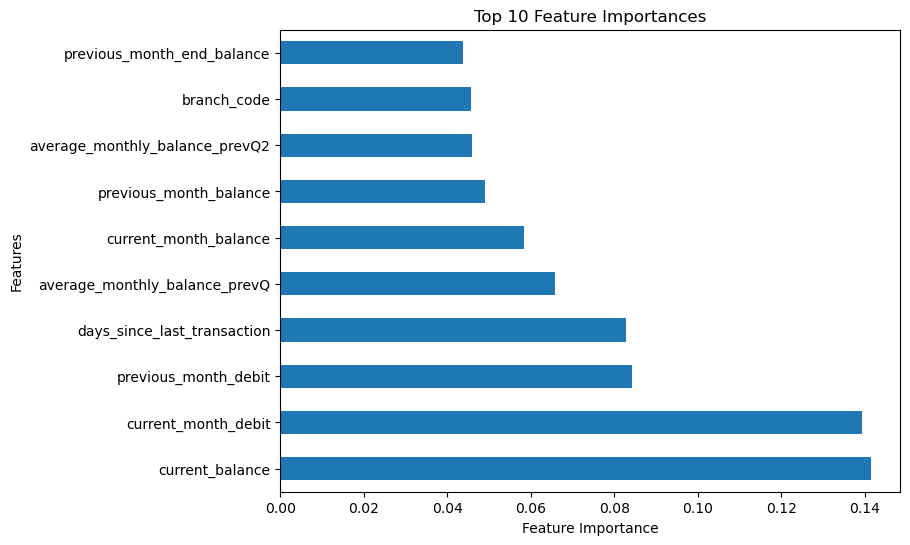

In [12]:
plt.figure(figsize=(8, 6))
feature_importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances')
plt.show()

In [13]:
# Filter the dataset to include only the top 10 features
X_train_res = X_train_res[most_important_features]
X_test = X_test[most_important_features]

## Building the Models

### Random Forest Models

In [14]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100],
    'max_depth': [30],
    'min_samples_split': [2],
}

# Define the StratifiedKFold object
cv = StratifiedKFold(n_splits=5)

# Create the GridSearchCV object. For scoring, use aucpr
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_res, y_train_res)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model using the best parameters
rf = RandomForestClassifier(**best_params)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=30)

In [15]:
# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("F1 Score: ", f1_score(y_test, y_pred_rf))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred_rf))
print("Specificity:", recall_score(y_test, y_pred_rf, pos_label=0))
print("Sensitivity:", recall_score(y_test, y_pred_rf, pos_label=1))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report: \n", classification_report(y_test, y_pred_rf))

Accuracy:  0.8064317902498975
F1 Score:  0.5771812080536913
ROC AUC Score:  0.7573411527861943
Specificity: 0.8378722321201324
Sensitivity: 0.6768100734522561
Confusion Matrix: 
 [[3292  637]
 [ 308  645]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.84      0.87      3929
           1       0.50      0.68      0.58       953

    accuracy                           0.81      4882
   macro avg       0.71      0.76      0.73      4882
weighted avg       0.83      0.81      0.82      4882



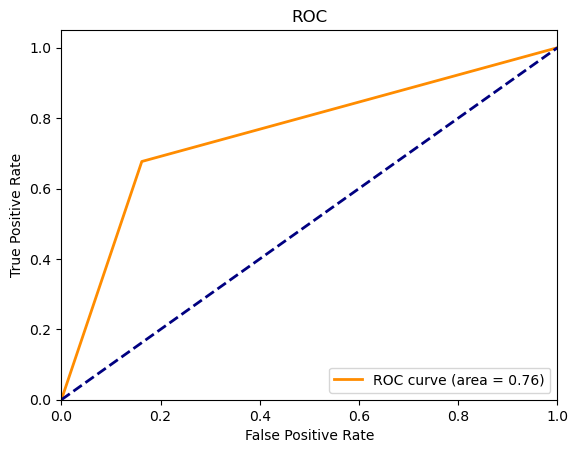

In [16]:
generate_ROC_curve(y_test, y_pred_rf)

In [17]:
generate_pkl(rf,model_results_path/Path("random_forest.pkl"))

Model exported successfully to model_results/random_forest.pkl


### ADA Boosting

In [18]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],          # Number of weak learners
    'learning_rate': [0.1, 0.5, 1.0]         # Learning rate
}

# Initialize AdaBoost classifier with base estimator
base_estimator = DecisionTreeClassifier()
adaboost_clf = AdaBoostClassifier(estimator=base_estimator, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(adaboost_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_res, y_train_res)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 50}
Best Score: 0.7345103386263679


In [19]:
# Evaluate the model with the best parameters
best_estimator = grid_search.best_estimator_
y_pred_ada = best_estimator.predict(X_test)

In [20]:
# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred_ada))
print("F1 Score: ", f1_score(y_test, y_pred_ada))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred_ada))
print("Specificity:", recall_score(y_test, y_pred_ada, pos_label=0))
print("Sensitivity:", recall_score(y_test, y_pred_ada, pos_label=1))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_ada))
print("Classification Report: \n", classification_report(y_test, y_pred_ada))

Accuracy:  0.7132322818517002
F1 Score:  0.45054945054945056
ROC AUC Score:  0.6712229695136949
Specificity: 0.7401374395520489
Sensitivity: 0.602308499475341
Confusion Matrix: 
 [[2908 1021]
 [ 379  574]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.74      0.81      3929
           1       0.36      0.60      0.45       953

    accuracy                           0.71      4882
   macro avg       0.62      0.67      0.63      4882
weighted avg       0.78      0.71      0.74      4882



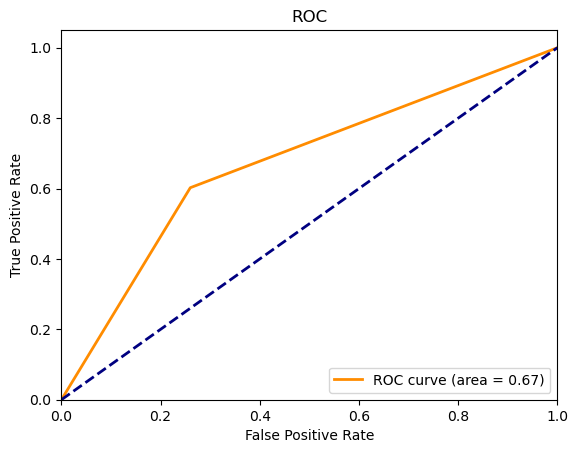

In [21]:
generate_ROC_curve(y_test, y_pred_ada)

In [22]:
generate_pkl(best_estimator,model_results_path/Path("ada_boost.pkl"))

Model exported successfully to model_results/ada_boost.pkl


### Logistic Regression

In [23]:
# Initialize the logistic regression model
logistic_reg = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model to the training data
logistic_reg.fit(X_train_res, y_train_res)

# Make predictions on the testing data
y_pred_logit = logistic_reg.predict(X_test)

In [24]:
# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred_logit))
print("F1 Score: ", f1_score(y_test, y_pred_logit))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred_logit))
print("Specificity:", recall_score(y_test, y_pred_logit, pos_label=0))
print("Sensitivity:", recall_score(y_test, y_pred_logit, pos_label=1))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_logit))
print("Classification Report: \n", classification_report(y_test, y_pred_logit))

Accuracy:  0.47439573945104463
F1 Score:  0.3268625393494229
ROC AUC Score:  0.5423117630704715
Specificity: 0.4308984474420972
Sensitivity: 0.6537250786988458
Confusion Matrix: 
 [[1693 2236]
 [ 330  623]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.43      0.57      3929
           1       0.22      0.65      0.33       953

    accuracy                           0.47      4882
   macro avg       0.53      0.54      0.45      4882
weighted avg       0.72      0.47      0.52      4882



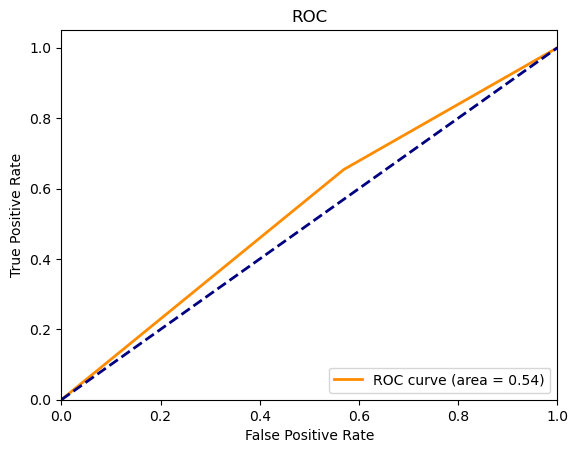

In [25]:
generate_ROC_curve(y_test, y_pred_logit)

In [26]:
generate_pkl(logistic_reg,model_results_path/Path("logit.pkl"))

Model exported successfully to model_results/logit.pkl


### XG Boosting

In [27]:
X_train_res.columns

Index(['average_monthly_balance_prevQ', 'average_monthly_balance_prevQ2',
       'branch_code', 'current_balance', 'current_month_balance',
       'current_month_debit', 'days_since_last_transaction',
       'previous_month_balance', 'previous_month_debit',
       'previous_month_end_balance'],
      dtype='object')

In [28]:
# Initialize the XG Boost model 
xg_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
xg_model.fit(X_train_res, y_train_res)

# Make predictions
y_pred_XG = xg_model.predict(X_test)

In [29]:
# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred_XG))
print("F1 Score: ", f1_score(y_test, y_pred_XG))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred_XG))
print("Specificity:", recall_score(y_test, y_pred_XG, pos_label=0))
print("Sensitivity:", recall_score(y_test, y_pred_XG, pos_label=1))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_XG))
print("Classification Report: \n", classification_report(y_test, y_pred_XG))

Accuracy:  0.8080704629250307
F1 Score:  0.5668053629218677
ROC AUC Score:  0.7456424194723925
Specificity: 0.8480529396793077
Sensitivity: 0.6432318992654774
Confusion Matrix: 
 [[3332  597]
 [ 340  613]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.85      0.88      3929
           1       0.51      0.64      0.57       953

    accuracy                           0.81      4882
   macro avg       0.71      0.75      0.72      4882
weighted avg       0.83      0.81      0.82      4882



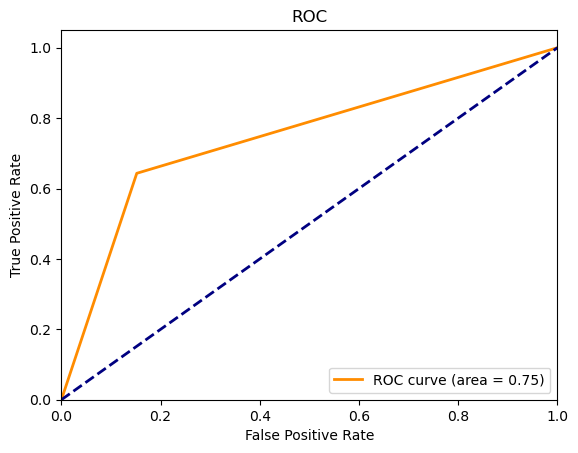

In [30]:
generate_ROC_curve(y_test, y_pred_XG)

In [31]:
generate_pkl(xg_model,model_results_path/Path("xg_model.pkl"))

Model exported successfully to model_results/xg_model.pkl


## Testing Pkl Files

In [40]:
# Sample Input
sample_input = {
            'current_balance': 0.05,
            'current_month_debit': 0.05,
            'previous_month_debit': 0.05,
            'current_month_balance': 0.05,
            'average_monthly_balance_prevQ': 0.05,
            'previous_month_balance': 0.05,
            'previous_month_end_balance': 0.05,
            'average_monthly_balance_prevQ2': 0.05,
            'days_since_last_transaction': 0.05,
            'branch_code':20
}

In [53]:
predict_from_pkl(model_results_path/Path("random_forest.pkl"),new_record=sample_input)

True